In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda, Reshape
from keras.layers.merge import Multiply
from keras.models import Model
from keras.layers.merge import Concatenate, Add
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D, AveragePooling1D
from keras.layers.convolutional import UpSampling1D, UpSampling2D
from keras.regularizers import l2, l1, l1_l2
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from keras import backend as K

def set_keras_num_threads(n_threads):
    from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.intra_op_parallelism_threads = n_threads
    config.inter_op_parallelism_threads = n_threads
    K.set_session(tf.Session(config=config))
    
set_keras_num_threads(2)

import tensorflow as tf
import h5py

In [101]:
with h5py.File('synthetic_motifs.h5', 'r') as f:
    X = f['X'][:]
    y = f['y'][:]
    positions = f['positions'][:]
    pwm = f['pwm'][:]
    motif_length = pwm.shape[1]
    window_size = X.shape[1]
    positions_pos = positions[y == 1]
    X_pos = X[y == 1]
    X_neg = X[y == 0]
    X_motif = np.empty((X_pos.shape[0], pwm.shape[1], X_pos.shape[2]), dtype=np.float32)
    for i in range(X_pos.shape[0]):
        X_motif[i] = X_pos[i, positions_pos[i]:(positions_pos[i] + motif_length)]

In [310]:
def categorical_crossentropy_numpy(y_true, y_pred):
    n_classes = y_pred.shape[-1]
    return np.sum(np.sum(np.log(y_pred)*(y_true.astype(np.bool)), axis=2), axis=1)

def categorical_accuracy_numpy(y_true, y_pred):
    is_equal = np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1).astype(np.float32)
    return np.mean(is_equal, axis=1)

def pwm_logL(pwm, X):
    logL = categorical_crossentropy_numpy(X, np.repeat(pwm.T[np.newaxis, :, :], X.shape[0], axis=0))
    return logL

pwm_logL(pwm, X_rand[:10])

array([-31.50484621, -16.21829114, -25.6659655 , -13.34580662,
       -31.02309954, -31.33767362, -27.57428071, -29.39283959,
       -37.27717336, -26.35125428])

In [226]:
n_pos = X_motif.shape[0]
n_neg = n_pos
logL_pos = categorical_crossentropy_numpy(X_motif, np.repeat(pwm.T[np.newaxis, :, :], n_pos, axis=0))
y_pos = np.ones(n_pos, dtype=np.int32)
X_rand = np.random.randint(X_motif.shape[2], size=(n_pos, X_motif.shape[1]))
X_rand = (X_rand[:, :, np.newaxis] == np.arange(X_motif.shape[2])[np.newaxis, np.newaxis, :]).astype(np.int32)
logL_neg = categorical_crossentropy_numpy(X_rand, np.repeat(pwm.T[np.newaxis, :, :], n_neg, axis=0))
y_neg = np.zeros(n_neg, dtype=np.int32)

In [306]:
logL_neg

array([-28.156076, -16.614714, -34.988773, ..., -39.89257 , -36.466244,
       -39.816475], dtype=float32)

In [227]:
roc_auc_score(np.concatenate([y_pos, y_neg]), np.concatenate([logL_pos, logL_neg]))

0.9872579749999999

In [300]:
def random_multinomial(p):
    '''Draw a sample from multinomial distributions
    Args:
        p: multinomial probabilities. The last dimension is the label.
    Returns:
        Samples drawn from each distribution in one-hot encoding.
    '''
    p_cum = np.cumsum(p, axis=-1)
    n_classes = p.shape[-1]
    q = np.random.uniform(size=p.shape)
    X_labels = np.argmax(q < p_cum, axis=-1)
    X = (np.expand_dims(X_labels, axis=-1) == np.arange(n_classes).reshape([1]*(len(p.shape) - 1) + [-1])).astype(np.int32)
    return X

def batch_generator(X, batch_size=25):
    '''Create a iterator that generates batches
    '''
    n_samples = X.shape[0]
    for i in range(n_samples//batch_size):
        yield X[(i*batch_size):((i + 1)*batch_size)]
    n_remains = n_samples%batch_size
    if n_remains > 0:
        yield X[-n_remains:]
        
def conv_network(input_layer):
    output = Conv1D(64, 8, padding='same')(input_layer)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Conv1D(64, 4, padding='same')(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Flatten()(output)
    return output

def deconv_network(input_layer):
    output = UpSampling1D(2)(input_layer)
    output = Conv1D(64, 4, padding='same')(output)
    output = Activation('relu')(output)
    output = UpSampling1D(2)(output)
    output = Conv1D(64, 8, padding='same')(output)
    output = Activation('relu')(output)
    output = Conv1D(4, 1, padding='same')(output)
    output = Lambda(lambda x: K.softmax(x, axis=2), name='output_softmax')(output)
    #output = Dense(64, kernel_regularizer=l2(0.0001))(output)
    return output
    
def sparse_autoencoder(window_size=128, n_channels=4, n_sampler=10, latent_size=2):
    input_layer = Input(shape=(window_size, n_channels))
    conv_out = conv_network(input_layer)
    latent = Dense(latent_size, name='latent')(conv_out)
    decoder_input = Dense(window_size//4*n_channels, activation='relu', name='latent_dense')(latent)
    decoder_input = Reshape((window_size//4, n_channels), name='latent_reshape')(decoder_input)
    output = deconv_network(decoder_input)
    model = Model(inputs=[input_layer], outputs=[output])
    return model

def sparse_autoencoder2(window_size=128, n_channels=4, latent_size=2):
    '''Encoders and decoders and multi-layer fully-connected networks.
    Input are motif instances.
    '''
    input_layer = Input(shape=(window_size, n_channels), name='input')
    encoder = Flatten(name='flatten')(input_layer)
    encoder = Dense(128, activation='relu', name='encoder_dense1')(encoder)
    encoder = Dense(64,  activation='relu', name='encoder_dense2')(encoder)
    latent = Dense(latent_size, activation='relu', name='latent')(encoder)
    decoder = Dense(64, activation='relu', name='decoder_dense1')(latent)
    decoder = Dense(128, activation='relu', name='decoder_dense2')(decoder)
    decoder = Dense(window_size*n_channels, name='decoder_dense3')(decoder)
    decoder = Reshape((window_size, n_channels), name='decoder_reshape')(decoder)
    decoder = Lambda(lambda x: K.softmax(x, axis=2), name='output_softmax')(decoder)
    model = Model(inputs=[input_layer], outputs=[decoder])
    return model
    
def variational_autoencoder(window_size=128, n_channels=4, n_sampler=10, latent_size=2):
    input_layer = Input(shape=(window_size, n_channels))
    conv_out = conv_network(input_layer)
    
    latent_params = Dense(latent_size*2, name='latent_params')(conv_out)
    latent_mean = Lambda(lambda x: K.expand_dims(x[:latent_size], axis=1), name='latent_mean')(latent_params)
    latent_logstd = Lambda(lambda x: K.expand_dims(x[latent_size:], axis=1), name='latent_logsd')(latent_params)
    latent_var = Lambda(lambda x: K.square(K.exp(x)), name='latent_std')(latent_logstd)
    standard_sampler = Lambda(lambda x: K.random_normal((K.shape(x)[0], latent_size)),
                              name='standard_sampler')(input_layer)
    latent_sampler = Lambda(lambda x: x[0]*x[2] + x[1], 
                            name='latent_sampler')([standard_sampler, latent_mean, latent_std])
    latent = Lamda(lambda x: K.reshape((-1, latent_size)), name='latent')(latent_sampler)
    
    decoder_input = Dense(window_size//4*n_channels, name='latent_dense')(latent)
    decoder_input = Reshape((window_size//4, n_channels), name='latent_reshape')(decoder_input)
    output = deconv_network(decoder_input)

    
class VariationalAutoencoder2(object):
    def __init__(self, window_size=128, n_channels=4, n_sampler=20, latent_size=2):
        '''Encoders and decoders and multi-layer fully-connected networks.
        Input are motif instances.
        '''
        input_layer = Input(shape=(window_size, n_channels), name='input')
        encoder = Flatten(name='flatten')(input_layer)
        encoder = Dense(128, activation='relu', name='encoder_dense1')(encoder)
        encoder = Dense(64,  activation='relu', name='encoder_dense2')(encoder)

        latent_params = Dense(latent_size*2, name='latent_params')(encoder)
        latent_mean = Lambda(lambda x: x[:, :latent_size], name='latent_mean')(latent_params)
        latent_logstd = Lambda(lambda x: x[:, latent_size:], name='latent_logstdd')(latent_params)
        latent_std = Lambda(lambda x: K.exp(x), name='latent_std')(latent_logstd)
        latent_var = Lambda(lambda x: K.square(x), name='latent_var')(latent_std)
        standard_sampler = Lambda(lambda x: K.random_normal((K.shape(x)[0], n_sampler, latent_size)),
                                  name='standard_sampler')(input_layer)
        latent_sampler = Lambda(lambda x: x[0]*K.expand_dims(x[2], axis=1) + K.expand_dims(x[1], axis=1), 
                                name='latent_sampler')([standard_sampler, latent_mean, latent_std])
        latent = Lambda(lambda x: K.reshape(x, (-1, latent_size)), name='latent')(latent_sampler)

        decoder = Dense(64, activation='relu', name='decoder_dense1')(latent)
        decoder = Dense(128, activation='relu', name='decoder_dense2')(decoder)
        decoder = Dense(window_size*n_channels, name='decoder_dense3')(decoder)
        decoder = Reshape((window_size, n_channels), name='decoder_reshape')(decoder)
        decoder = Lambda(lambda x: K.softmax(x, axis=-1), name='output_softmax')(decoder)
        decoder = Lambda(lambda x: K.mean(K.reshape(x, (-1, n_sampler, window_size, n_channels)), axis=1),
                         name='output_mean')(decoder)

        def kl_loss(y_true, y_pred):
            KL = 0.5*K.sum(latent_var + K.square(latent_mean) - 1 - K.log(latent_var), axis=1)
            return KL
        
        def nll_loss(y_true, y_pred):
            y_true = K.reshape(y_true, (-1, n_channels))
            y_pred = K.reshape(y_pred, (-1, n_channels))
            NLL = K.categorical_crossentropy(y_true, y_pred)
            NLL = K.sum(K.reshape(NLL, (-1, window_size)), axis=1)
            return NLL
            
        def vae_loss(y_true, y_pred):
            return nll_loss(y_true, y_pred) + kl_loss(y_true, y_pred)    

        ll_input = Input(shape=(window_size, n_channels), name='ll_input')
        ll = -nll_loss(ll_input, decoder)
        model = Model(inputs=[input_layer], outputs=[decoder])
        model.compile(loss=vae_loss,
                      metrics=['categorical_accuracy', kl_loss, nll_loss],
                      optimizer='Adam')
        
        self.latent_size = latent_size
        self.window_size = window_size
        self.n_channels = n_channels
        self.n_sampler = n_sampler
        
        self.ll_function = K.function([ll_input, latent_sampler], [ll])
        # returns multinomial probabilities
        self.sample_function = K.function([latent], [decoder])
        
        self.input_layer = input_layer
        self.model = model
        self.latent_mean = latent_mean
        self.latent_std = latent_std
        self.latent_params = latent_params
        self.latent_sampler = latent_sampler
        self.decoder = decoder
    
    def logL(self, X, n_sampler=20, batch_size = 100):
        ll_values = []
        for X_batch in batch_generator(X, batch_size=batch_size):
            sampler_batch = np.random.normal(size=(X_batch.shape[0], n_sampler, self.latent_size))
            ll_values.append(self.ll_function([X_batch, sampler_batch])[0])
        return np.concatenate(ll_values)

    def sample(self, size=1, batch_size = 100):
        X = []
        for indices in batch_generator(np.arange(size), batch_size=batch_size):
            sampler_batch = np.random.normal(size=(indices.shape[0], self.latent_size))
            p = self.sample_function([sampler_batch])[0]
            X.append(random_multinomial(p))
        X = np.concatenate(X, axis=0)
        return X

#sparse_model = sparse_autoencoder(window_size, latent_size=128)
#sparse_model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='Adam')
#sparse_model.summary()

#sparse_model2 = sparse_autoencoder2(motif_length, latent_size=3)
#sparse_model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='Adam')
#sparse_model2.summary()
vae_model2 = VariationalAutoencoder2(motif_length, latent_size=4)
vae_model2.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 10, 4)        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 40)           0           input[0][0]                      
__________________________________________________________________________________________________
encoder_dense1 (Dense)          (None, 128)          5248        flatten[0][0]                    
__________________________________________________________________________________________________
encoder_dense2 (Dense)          (None, 64)           8256        encoder_dense1[0][0]             
__________________________________________________________________________________________________
latent_par

In [304]:
vae_samples = vae_model2.sample(size=100)

In [305]:
vae_model2.logL(vae_samples)

array([ -7.016315,  -8.379493,  -6.37033 ,  -4.72492 , -10.511507],
      dtype=float32)

In [311]:
pwm_logL(pwm, vae_samples)

array([ -6.63342797,  -9.9420617 , -10.41156909,  -8.10008117,
       -14.54659177])

In [271]:
logL_pos = vae_model2.logL(X_motif)
logL_neg = vae_model2.logL(X_rand)

In [275]:
roc_auc_score(np.concatenate([np.ones(logL_pos.shape[0]), np.zeros(logL_neg.shape[0])]),
                             np.concatenate([logL_pos, logL_neg]))

0.9957775799999999

In [248]:
sparse_model2.fit(X_motif, X_motif, batch_size=50, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 1s 63us/step - loss: 0.1510 - categorical_accuracy: 0.9400
Epoch 2/10
10000/10000 [==============================] - 1s 63us/step - loss: 0.1557 - categorical_accuracy: 0.9384
Epoch 3/10
10000/10000 [==============================] - 1s 63us/step - loss: 0.1508 - categorical_accuracy: 0.9403
Epoch 4/10
10000/10000 [==============================] - 1s 62us/step - loss: 0.1514 - categorical_accuracy: 0.9404
Epoch 5/10
10000/10000 [==============================] - 1s 62us/step - loss: 0.1492 - categorical_accuracy: 0.9417
Epoch 6/10
10000/10000 [==============================] - 1s 63us/step - loss: 0.1538 - categorical_accuracy: 0.9395
Epoch 7/10
10000/10000 [==============================] - 1s 62us/step - loss: 0.1498 - categorical_accuracy: 0.9413
Epoch 8/10
10000/10000 [==============================] - 1s 64us/step - loss: 0.1511 - categorical_accuracy: 0.9407
Epoch 9/10
10000/10000 [==============================] - 1s 63u

In [302]:
vae_model2.model.fit(X_motif, X_motif, batch_size=50, epochs=20)

Epoch 1/20
10000/10000 [==============================] - 3s 329us/step - loss: 8.4021 - categorical_accuracy: 0.6637 - kl_loss: 0.3215 - nll_loss: 8.0806
Epoch 2/20
10000/10000 [==============================] - 1s 82us/step - loss: 7.0407 - categorical_accuracy: 0.7321 - kl_loss: 0.7110 - nll_loss: 6.3297
Epoch 3/20
10000/10000 [==============================] - 1s 80us/step - loss: 6.7943 - categorical_accuracy: 0.7367 - kl_loss: 0.8405 - nll_loss: 5.9538
Epoch 4/20
10000/10000 [==============================] - 1s 81us/step - loss: 6.6931 - categorical_accuracy: 0.7392 - kl_loss: 0.9036 - nll_loss: 5.7894
Epoch 5/20
10000/10000 [==============================] - 1s 81us/step - loss: 6.6352 - categorical_accuracy: 0.7405 - kl_loss: 0.9463 - nll_loss: 5.6889
Epoch 6/20
10000/10000 [==============================] - 1s 80us/step - loss: 6.6016 - categorical_accuracy: 0.7412 - kl_loss: 0.9662 - nll_loss: 5.6354
Epoch 7/20
10000/10000 [==============================] - 1s 81us/step - lo

In [194]:
get_latent_params = K.function([vae_model2.input_layer], [vae_model2.latent_params])
latent_params_values = get_latent_params([X_motif[:1000]])[0]

(array([ 3.,  1.,  0.,  4.,  2.,  1.,  4.,  2.,  3., 21., 31., 36., 39.,
        59., 42., 34., 22., 13., 11., 18., 21.,  4., 19., 30., 55., 60.,
        58., 67., 70., 29., 25., 11., 11.,  3.,  1.,  3.,  0.,  2.,  4.,
        23., 15., 31., 33., 21., 21., 20.,  9.,  3.,  3.,  2.]),
 array([-1.12599087, -1.09213012, -1.05826937, -1.02440862, -0.99054788,
        -0.95668713, -0.92282638, -0.88896563, -0.85510489, -0.82124414,
        -0.78738339, -0.75352264, -0.71966189, -0.68580115, -0.6519404 ,
        -0.61807965, -0.5842189 , -0.55035815, -0.51649741, -0.48263666,
        -0.44877591, -0.41491516, -0.38105442, -0.34719367, -0.31333292,
        -0.27947217, -0.24561142, -0.21175068, -0.17788993, -0.14402918,
        -0.11016843, -0.07630769, -0.04244694, -0.00858619,  0.02527456,
         0.05913531,  0.09299605,  0.1268568 ,  0.16071755,  0.1945783 ,
         0.22843904,  0.26229979,  0.29616054,  0.33002129,  0.36388204,
         0.39774278,  0.43160353,  0.46546428,  0.49932503,

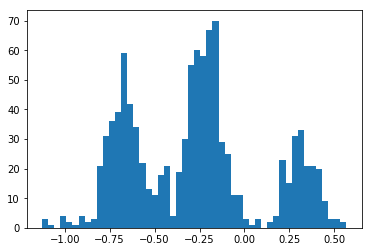

In [202]:
hist(latent_params_values[:, 5], bins=50)

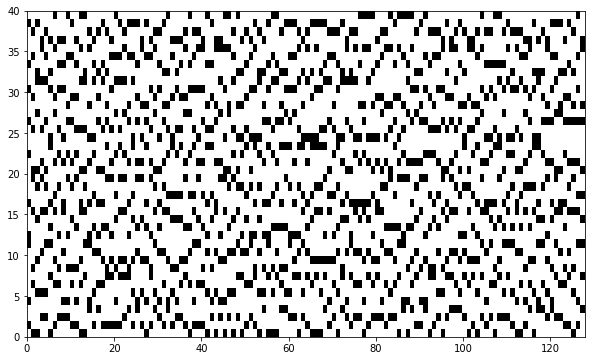

In [40]:
def plot_onehot(X):
    X = np.swapaxes(X, 1, 2).reshape((-1, X.shape[1]))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.pcolor(X, cmap=cm.Greys)
plot_onehot(X_pos[:10])

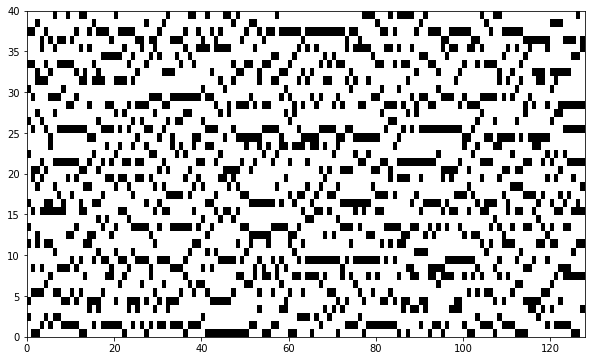

In [88]:
X_pred = sparse_model.predict(X_pos[:10])
X_pred_onehot = (X_pred >= np.max(X_pred, axis=-1, keepdims=True)).astype(np.float32)
plot_onehot(X_pred_onehot[:10])

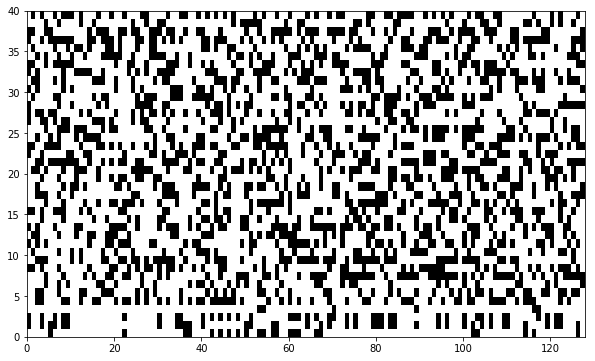

In [96]:
plot_onehot((X_pred_onehot[:10] != X[:10]).astype(np.float32))

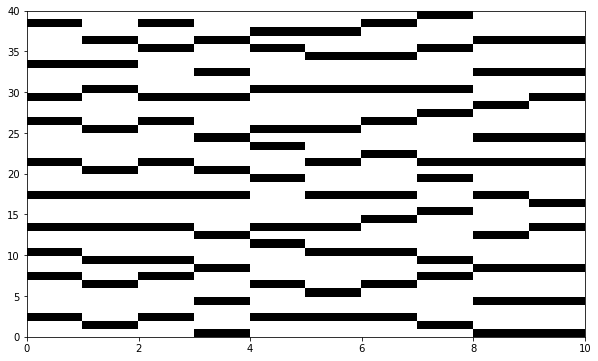

In [105]:
plot_onehot(X_motif[:10])

In [314]:
vae_model2.latent_params

<tf.Tensor 'latent_params_46/BiasAdd:0' shape=(?, 8) dtype=float32>

In [322]:
def keras_random_binomial(shape, p=0.0, dtype=None, seed=None):
    return K.eval(K.random_binomial(shape, p, dtype, seed))
keras_random_binomial([10, 4], p=0.75)

array([[1., 1., 1., 1.],
       [1., 1., 0., 1.],
       [1., 0., 1., 0.],
       [1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 0., 1., 1.]], dtype=float32)

In [315]:
K.eval?

In [320]:
K.eval(K.random_binomial([3, 4], p=0.5))

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 0., 0.]], dtype=float32)

In [369]:
def oneclass_network(window_size=128, n_channels=4):
    input_layer = Input(shape=(window_size, n_channels))
    output = Flatten(name='flatten')(input_layer)
    #output = Dense(64, activation='relu', kernel_regularizer=l1_l2(0.5, 0.5), name='dense1')(output)
    #output = Dense(64, activation='relu', kernel_regularizer=l1_l2(0.5, 0.5), name='dense2')(output)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(1e2, 1e2), name='dense3')(output)
    model = Model(inputs=[input_layer], outputs=[output])
    
    def nll_loss(y_true, y_pred):
        return -K.mean(y_pred)
    
    model.compile(loss=nll_loss, optimizer='Adam')
    return model

oneclass_model = oneclass_network(window_size=X.shape[1], n_channels=X.shape[2])
oneclass_model.fit(X_pos, np.zeros((X_pos.shape[0], 1)), batch_size=25, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 4s 360us/step - loss: 272.6247
Epoch 2/10
10000/10000 [==============================] - 1s 79us/step - loss: 4.8446
Epoch 3/10
10000/10000 [==============================] - 1s 78us/step - loss: 4.8645
Epoch 4/10
10000/10000 [==============================] - 1s 77us/step - loss: 4.7294
Epoch 5/10
10000/10000 [==============================] - 1s 76us/step - loss: 4.2588
Epoch 6/10
10000/10000 [==============================] - 1s 76us/step - loss: 4.1643
Epoch 7/10
10000/10000 [==============================] - 1s 77us/step - loss: 4.1975
Epoch 8/10
10000/10000 [==============================] - 1s 77us/step - loss: 4.4201
Epoch 9/10
10000/10000 [==============================] - 1s 77us/step - loss: 4.4430
Epoch 10/10
10000/10000 [==============================] - 1s 76us/step - loss: 4.5866


In [370]:
oneclass_model.predict(X_pos[:10])

array([[0.95063215],
       [0.9506677 ],
       [0.95058906],
       [0.950588  ],
       [0.95062935],
       [0.95065355],
       [0.95071423],
       [0.95065796],
       [0.95060617],
       [0.95061564]], dtype=float32)

In [337]:
l1_l2?